In [67]:
import os, sys, gc, argparse, numpy as np

import torch
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable

import os, sys, gc, argparse, numpy as np
import torch
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import threshold_otsu, threshold_local  # threshold_adaptive
from skimage.morphology import binary_closing, binary_opening, binary_erosion, binary_dilation
from skimage.exposure import rescale_intensity
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
import cv2
import warnings

warnings.filterwarnings("ignore")
import os.path as osp
import json
import torchvision.transforms.functional as TF
from skimage.filters import threshold_otsu
%matplotlib inline

# this will set the notebook to display all the executed statement value on the screen
#print multiple statement in single line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [68]:
from google.colab import drive
drive.mount('/content/gdrive')

root = 'gdrive/MyDrive/Datascience/ARProject/Tryon/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [69]:
def get_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument("dataroot", default="data")
    parser.add_argument("datamode", default="train")
    parser.add_argument("stage", default="Stage1", help='Stage1, Stage2, Stage3')
    parser.add_argument('Stage1', type=str, default='pre_trained_models/Stage_1/Gan_9.pth', help='load_Stage_1_model')
    parser.add_argument('Stage2', type=str, default='pre_trained_models/Stage_2/Gan_7.pth', help='load_Stage_2_model')
    parser.add_argument('Stage3', type=str, default='pre_trained_models/Stage_3/Gan_9.pth', help='load_Stage_3_model')
    parser.add_argument('results_Stage1', type=str, default='results/test/Stage1', help='save results')
    parser.add_argument('results_Stage2', type=str, default='results/test/Stage2', help='save results')
    parser.add_argument('results_Stage3', type=str, default='results/test/Stage3', help='save results')
    parser.add_argument('model_image', default="000829_0.jpg", type=str, help='Model of the person wearing cloth')
    parser.add_argument('reference_image', default="006851_1.jpg", type=str, help='Reference cloth to swap')

    argv = ["", "data", "train", "Stage3",
            "gdrive/MyDrive/Datascience/ARProject/Tryon/pre_trained_models/Stage_1/Gan_44.pth", "gdrive/MyDrive/Datascience/ARProject/Tryon/pre_trained_models/Stage_2/Gan_42.pth",
            "gdrive/MyDrive/Datascience/ARProject/Tryon/pre_trained_models/Stage_3/Gan_48.pth",
            "gdrive/MyDrive/Datascience/ARProject/Tryon/results/test/Stage1", "results/test/Stage2/", "results/test/Stage3/",
            "000112_0.jpg", "000023_1.jpg"]
    opt = parser.parse_args(argv[1:])
    return opt

In [70]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from imgaug import augmenters as iaa
from torch.autograd import Variable


# Initialize kernel weights to uniform. We are not using BatchNorm in final code.
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)


# LambdaLR is use for Learning rate scheduling (Not used in main code).
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)


class commonFunctions:
    def name(self):
        return 'commonFunctions'

    def __init__(self):
        super(commonFunctions, self).__init__()

    def createDir(self, path):
        if not os.path.exists(path):
            os.makedirs(path)

    def display_img(self, img, cmap=None):
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111)
        ax.imshow(img, cmap)


class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            #         iaa.Scale((128, 128)),
            #         iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            #         iaa.Fliplr(0.5),
            #         iaa.Affine(rotate=(-40, 40), mode='symmetric'),
            iaa.Affine(rotate=40, mode='symmetric')
            #         iaa.Sometimes(0.25,
            #                       iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
            #                                  iaa.CoarseDropout(0.1, size_percent=0.5)])),
            #         iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)


class ImgAugTransformStitching:
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self.aug = iaa.Sequential([
#         iaa.Scale((128, 128)),
#         iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
#         iaa.Fliplr(0.5),
        iaa.Affine(rotate=40, mode='symmetric'),
#             iaa.Affine( rotate = 20 , mode='symmetric')
#         iaa.Sometimes(0.25,
#                       iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
#                                  iaa.CoarseDropout(0.1, size_percent=0.5)])),
#         iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        iaa.Affine(
            translate_percent={"x":0.2, "y": 0.1},
#             rotate=(-45, 45),
#             shear=(-16, 16),
#             order=[0, 1],
#             cval=(0, 255),
            mode='symmetric'
        )
    ])
    def __call__(self, img, img1, img2):
        img = np.array(img)
        img1 = np.array(img1)
        img2 = np.array(img2)

        return self.aug.augment_image(img), self.aug.augment_image(img1), self.aug.augment_image(img2)

class ImgAugTransformRefine:
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self.aug = iaa.Sequential([
        iaa.Affine(
            translate_percent={"x":0.2, "y": 0.1},
            mode='symmetric'
        )
    ])
    def __call__(self, img, img1, img2):
        img = np.array(img)
        img1 = np.array(img1)
        img2 = np.array(img2)

        return self.aug.augment_image(img), self.aug.augment_image(img1), self.aug.augment_image(img2)

# Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
# ReplayBuffer was first introduced in the above mentioned paper, It's effect mathematically has been supported in
# latest ICLR paper ProbGAN. Replay buffer uses previous data as prior for the Discriminator which it has seen already.
# Page 5 of the paper, just over Theory section.
# Hence we propose to maintain a subset of discriminators by subsampling the whole sequence of discriminators.

class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


In [71]:
class data_loader():
    def __init__(self, mode="train"):
        path_ = os.getcwd()
        self.root = path_ + '/gdrive/MyDrive/Datascience/ARProject/Tryon/data/'
        self.datamode = mode  # train or test or self-define
        self.fine_height = 128
        self.fine_width = 128
        self.radius = 3
        self.data_path = osp.join(self.root, self.datamode)
        self.transform = transforms.Compose([transforms.Resize((self.fine_height, self.fine_height)), \
 \
                                             transforms.ToTensor(), \
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.transform_input = transforms.Compose([ImgAugTransform(), \
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.rotate = ImgAugTransform()

    def transformData(self, src, mask, target, cloth, skel, face):
        # Resize
        resize = transforms.Resize(size=(128, 128))
        src = resize(src)  # Source with missing cloth
        mask = resize(mask)  # mask of the missing cloth
        target = resize(target)  # target/ Ground truth
        cloth = resize(cloth)  # Cloth ground truth, how it should look before applying
        skel = resize(skel)  # skeleton
        face = resize(face)  # head

        # src = self.rotate(src)
        # mask = self.rotate(mask)
        # target = self.rotate(target)
        # cloth = self.rotate(cloth)
        # skel = self.rotate(skel)

        src = TF.to_tensor(src)
        mask = TF.to_tensor(mask)
        target = TF.to_tensor(target)
        cloth = TF.to_tensor(cloth)
        skel = TF.to_tensor(skel)

        src = TF.normalize(src, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        mask = TF.normalize(mask, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        target = TF.normalize(target, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        cloth = TF.normalize(cloth, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        skel = TF.normalize(skel, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        return src, mask, target, cloth, skel, face

    def get_binary_from_img(self, image_name):
        loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
        """load image, returns cuda tensor"""
        image = Image.fromarray(np.uint8(image_name))
        image = loader2(image).float()
        better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
        better_contrast[better_contrast > 1] = 1
        #     print(lol.shape)

        thresh = threshold_otsu(better_contrast)
        binary = better_contrast > thresh
        return binary  # assumes that you're using GPU

    def get_binary(self, image_name):
        loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
        """load image, returns cuda tensor"""
        image = Image.open(image_name)
        image = loader2(image).float()
        better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
        better_contrast[better_contrast > 1] = 1
        #     print(lol.shape)

        thresh = threshold_otsu(better_contrast)
        binary = better_contrast > thresh
        return binary  # assumes that you're using GPU

    def get_img(self, im_name, c_name):

        # person image
        im = plt.imread(osp.join(self.data_path, 'image', im_name))
        cm = plt.imread(osp.join(self.data_path, 'cloth', c_name))

        # print(im)
        # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        #plt.imshow(im)
        #plt.imshow(cm)

        #         im = self.transform(im) # [-1,1]

        # load parsing image

        parse_name = im_name.replace('.jpg', '.png')
        im_parse = Image.open(osp.join(self.data_path, 'image-parse', parse_name))
        parse_array = np.array(im_parse)
        #         parse_shape = (parse_array > 0).astype(np.float32)
        parse_head = (parse_array == 1).astype(np.float32) + \
                     (parse_array == 2).astype(np.float32) + \
                     (parse_array == 4).astype(np.float32) + \
                     (parse_array == 13).astype(np.float32)

        parse_cloth = (parse_array == 5).astype(np.float32) + \
                      (parse_array == 6).astype(np.float32) + \
                      (parse_array == 7).astype(np.float32) + \
                      (parse_array == 9).astype(np.float32) + \
                      (parse_array == 15).astype(np.float32) + (parse_array == 3).astype(np.float32) + (
                              parse_array == 14).astype(np.float32)

        pcm = self.get_binary_from_img(parse_cloth)
        phead = self.get_binary_from_img(parse_head)  # [0,1]
        im_h = im * phead - (1 - phead)

        pose_name = im_name.replace('.jpg', '_keypoints.json')
        with open(osp.join(self.data_path, 'pose', pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1, 3))

        point_num = pose_data.shape[0]
        r = 7  # self.radius
        #         pdb.set_trace()
        coop = {}
        coop2 = {}
        ai = 0
        for lol, i in enumerate(
                [1, 2, 3, 4, 5, 6, 7, 8, 11]):  # leaving out head and legs joints, heap and hands are kept
            pointx = pose_data[i, 0]
            pointy = pose_data[i, 1]
            if pointx > 1 and pointy > 1:
                coop[ai] = (pointx, pointy)
                coop2[ai] = (pointx, pointy)
                ai = ai + 1
            else:
                coop2[ai] = (pointx, pointy)
                ai = ai + 1

        # creating skeleton
        bone_list = [[x[0], x[1]] for key, x in coop2.items()]
        #         bone_list = bone_list.numpy()
        bone_list = np.array(bone_list) - 1
        itemindex = np.where(bone_list == -1)
        if len(itemindex[0]) == 0:
            it = 100
        else:
            it = np.unique(itemindex[0])

        one_map = Image.new('RGB', (192, 256))
        draw = ImageDraw.Draw(one_map)
        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 1)).all():
            draw.line((bone_list[0][0], bone_list[0][1], bone_list[1][0], bone_list[1][1]), fill='red', width=14)
        if np.logical_not(np.isin(it, 1)).all() and np.logical_not(np.isin(it, 2)).all():
            draw.line((bone_list[1][0], bone_list[1][1], bone_list[2][0], bone_list[2][1]), fill='blue', width=14)
        if np.logical_not(np.isin(it, 3)).all() and np.logical_not(np.isin(it, 2)).all():
            draw.line((bone_list[2][0], bone_list[2][1], bone_list[3][0], bone_list[3][1]), fill='white', width=14)
        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 4)).all():
            draw.line((bone_list[0][0], bone_list[0][1], bone_list[4][0], bone_list[4][1]), fill='orange', width=14)
        if np.logical_not(np.isin(it, 4)).all() and np.logical_not(np.isin(it, 5)).all():
            draw.line((bone_list[4][0], bone_list[4][1], bone_list[5][0], bone_list[5][1]), fill='orchid', width=14)
        if np.logical_not(np.isin(it, 6)).all() and np.logical_not(np.isin(it, 5)).all():
            draw.line((bone_list[5][0], bone_list[5][1], bone_list[6][0], bone_list[6][1]), fill='yellow', width=14)

        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 1)).all():
            draw.line((bone_list[1][0], bone_list[1][1], bone_list[7][0], bone_list[7][1]), fill='gold', width=14)
        if np.logical_not(np.isin(it, 4)).all() and np.logical_not(np.isin(it, 8)).all():
            draw.line((bone_list[4][0], bone_list[4][1], bone_list[8][0], bone_list[8][1]), fill='pink', width=14)
        if np.logical_not(np.isin(it, 7)).all() and np.logical_not(np.isin(it, 8)).all():
            draw.line((bone_list[7][0], bone_list[7][1], bone_list[8][0], bone_list[8][1]), fill='brown', width=14)

        source = im * pcm
        #         face = im*(1-pcm)
        source[source == 0] = 255
        #         face[face==0]=255
        mask = plt.imread(osp.join(self.data_path, 'nested_unet_msk', im_name))

        lol = self.get_binary(osp.join(self.data_path, 'nested_unet_msk', im_name))
        lol2 = source * (1 - lol)
        lol2[lol2 == 0] = 255

        lol3 = source * (lol)
        lol3[lol3 == 0] = 255

        input = Image.fromarray(np.uint8(lol2))
        mask = Image.fromarray(np.uint8(mask))
        style = Image.fromarray(np.uint8(lol3))
        target = Image.fromarray(np.uint8(source))
        cloth = Image.fromarray(np.uint8(cm))
        face = Image.fromarray(np.uint8(im_h))

        style_ = self.transform(style)
        cloth = self.transform(cloth)
        face = self.transform(face)

        source, mask, target, targ, skel, face = self.transformData(input, mask, target, style, one_map, face)
        del lol3, lol2, pcm, im, parse_cloth, im_parse, lol
        return source, mask, style_, target, targ, skel, cloth, face

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# ResNet module to process the incoming filters. We are using Instance Norm replacing traditional BatchNorm.
# BatchNorm doesn't plays any significant role, since our batch is very small, another thing we observed is
# that the feature maps don't face covariate shift in ResNet block as the dataset are very close to each other.
# removing Norm from ResNet block doesn't affects the model result.

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()

        conv_block = [nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.InstanceNorm2d(in_features),
                      nn.ReLU(inplace=True),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, out_features, 3),
                      nn.InstanceNorm2d(out_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class ConvBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ConvBlock, self).__init__()

        conv_block = [nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.InstanceNorm2d(in_features),
                      nn.ReLU(inplace=True),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, out_features, 3),
                      nn.InstanceNorm2d(out_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)


# Over the cause of GAN history we did infer that if we replace unknown region with Noise, then GANs can effectively
# generate the missing regions (effectively implies to generate something).
# We didn't test with different Noise, and their affects in detail.
class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, mask):
        #         pdb.set_trace()
        noise = torch.randn(1, 1, image.shape[2], image.shape[3]).cuda()
        mask = mask[:, :1, :, :].repeat(1, image.shape[1], 1, 1)
        return image + self.weight * noise * mask


def swish(x):
    return x * F.sigmoid(x)


def get_mean_var(c):
    n_batch, n_ch, h, w = c.size()

    c_view = c.view(n_batch, n_ch, h * w)
    c_mean = c_view.mean(2)

    c_mean = c_mean.view(n_batch, n_ch, 1, 1).expand_as(c)
    c_var = c_view.var(2)
    c_var = c_var.view(n_batch, n_ch, 1, 1).expand_as(c)
    # c_var = c_var * (h * w - 1) / float(h * w)  # unbiased variance

    return c_mean, c_var


# model_ds downsamples the feature maps, we use stride = 2 to downsample feature maps instead of
# max pooling layer which is not learnable.
class model_ds(nn.Module):
    def __init__(self, in_features, out_features):
        super(model_ds, self).__init__()

        conv_block = [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)


# model_up Upsamples the feature maps again with a layer which is learnable, we didn't use any other method since
# nn.Upsample has no learnable weights, the other layer that we could have tried is sub-pixel which also learns to
# upsample / downsmaple.
class model_up(nn.Module):
    def __init__(self, in_features, out_features):
        super(model_up, self).__init__()

        conv_block = [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)


class transform_layer(nn.Module):

    def __init__(self, input_nc, in_features, out_features):
        super(transform_layer, self).__init__()
        self.channels = in_features

        self.convblock = ConvBlock(in_features + in_features, out_features)
        self.up_conv = nn.Conv2d(in_features * 2, in_features, 3, 1, 1)
        self.down_conv = nn.Sequential(
            nn.Conv2d(64, in_features // 4, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(in_features // 4, in_features // 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(in_features // 2, in_features, 1, 1),
            nn.ReLU()
        )
        self.noise = NoiseInjection(in_features)

        self.convblock_ = ConvBlock(in_features + 64, out_features)

        self.vgg_block = nn.Sequential(
            nn.Conv2d(input_nc, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 1, 1),
            nn.ReLU()
        )

    def forward(self, x, mask=None, style=None, mode='D'):
        #         pdb.set_trace()
        if mode == 'C':
            style = F.upsample(style, size=(x.shape[2], x.shape[2]), mode='bilinear')

            style = self.vgg_block(style)
            concat = torch.cat([x, style], 1)

            out = (self.convblock_(concat))
            return out, style
        else:
            mask = F.upsample(mask, size=(x.shape[2], x.shape[2]), mode='bilinear')
            x = self.noise(x, mask)
            #             style = F.upsample(style, size=(x.shape[2],x.shape[2]), mode='bilinear')

            style = self.down_conv(style)
            concat = torch.cat([x, style], 1)

            out = (self.convblock(concat) + style)
            return out


class transform_up_layer(nn.Module):
    def __init__(self, in_features, out_features, diff=False):
        super(transform_up_layer, self).__init__()
        self.channels = in_features

        if diff == True:
            self.convblock = ConvBlock(in_features * 2 + in_features, out_features)
        else:
            self.convblock = ConvBlock(in_features * 2, out_features)
        self.up_conv = nn.Sequential(
            nn.Conv2d(in_features * 2, in_features, 3, 1, 1),
            nn.ReLU()
        )

    def forward(self, x, y, mode="down"):

        y = self.up_conv(y)
        concat = torch.cat([x, y], 1)

        out = self.convblock(concat)

        #         out = self.adain(out,style)

        return out


class GeneratorCoarse(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=1):
        super(GeneratorCoarse, self).__init__()
        in_features = 64

        self.model_input_cloth = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc + 1, in_features, 7),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True)
        )

        self.block128 = nn.Sequential(
            ResidualBlock(in_features, in_features)
        )
        self.block128_transform = transform_layer(input_nc, in_features, in_features)

        self.block64 = nn.Sequential(
            model_ds(in_features, in_features * 2),
            ResidualBlock(in_features * 2, in_features * 2)
        )
        self.block64_transform = transform_layer(input_nc, in_features * 2, in_features * 2)

        self.block32 = nn.Sequential(
            model_ds(in_features * 2, in_features * 4),
            ResidualBlock(in_features * 4, in_features * 4)
        )
        self.block32_transform = transform_layer(input_nc, in_features * 4, in_features * 4)

        self.block16 = nn.Sequential(
            model_ds(in_features * 4, in_features * 8),
            ResidualBlock(in_features * 8, in_features * 8)
        )
        self.block16_transform = transform_layer(input_nc, in_features * 8, in_features * 8)
        self.block8 = nn.Sequential(
            model_ds(in_features * 8, in_features * 8),
            ResidualBlock(in_features * 8, in_features * 8)
        )
        self.block8_transform = transform_layer(input_nc, in_features * 8, in_features * 8)
        self.block4 = nn.Sequential(
            model_ds(in_features * 8, in_features * 8),
            ResidualBlock(in_features * 8, in_features * 8)
        )
        self.block4_transform = transform_layer(input_nc, in_features * 8, in_features * 8)

        self.block4_up = nn.Sequential(
            nn.Conv2d(in_features * 8, in_features * 4, 3, 1, 1),
            ResidualBlock(in_features * 4, in_features * 4)
        )
        self.block4_up_transform = transform_up_layer(in_features * 4, in_features * 8)

        self.block8_up = nn.Sequential(
            model_up(in_features * 8, in_features * 4),
            ResidualBlock(in_features * 4, in_features * 4)
        )
        self.block8_up_transform = transform_up_layer(in_features * 4, in_features * 8)

        self.block16_up = nn.Sequential(
            model_up(in_features * 8, in_features * 4),
            ResidualBlock(in_features * 4, in_features * 4)
        )
        self.block16_up_transform = transform_up_layer(in_features * 4, in_features * 8)

        self.block32_up = nn.Sequential(
            model_up(in_features * 8, in_features * 4),
            ResidualBlock(in_features * 4, in_features * 4)
        )
        self.block32_up_transform = transform_up_layer(in_features * 2, in_features * 4, True)

        self.block64_up = nn.Sequential(
            model_up(in_features * 4, in_features * 2),
            ResidualBlock(in_features * 2, in_features * 2)
        )
        self.block64_up_transform = transform_up_layer(in_features, in_features * 2, True)

        self.block128_up = nn.Sequential(
            model_up(in_features * 2, in_features),
            ResidualBlock(in_features, in_features)
        )

        self.block128_up_transform = transform_up_layer(in_features // 2, in_features, True)

        self.model_output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_features, output_nc, 7),
            nn.Tanh()
        )
    def _conv_layer_set(self, in_c, out_c):
        model_input = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_c, out_c, 7, padding=0),
            nn.InstanceNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    # forward function
    def forward(self, src, *input):
        in_features = 64
        conds = []
        for cond in input:
            conds.append(cond)
        conds.append(src)

        style = torch.cat(conds, 1)
        y = torch.cat([torch.randn(1, 1, src.shape[2], src.shape[3]), style], 1)

        y = self.model_input_cloth(y)

        y128 = self.block128(y)
        y128, s_128 = self.block128_transform(x=y128, style=style, mode="C")

        y64 = self.block64(y128)
        y64, s_64 = self.block64_transform(x=y64, style=style, mode="C")

        y32 = self.block32(y64)
        y32, s_32 = self.block32_transform(x=y32, style=style, mode="C")

        y16 = self.block16(y32)
        y16, s_16 = self.block16_transform(x=y16, style=style, mode="C")

        y8 = self.block8(y16)
        y8, s_8 = self.block8_transform(x=y8, style=style, mode="C")

        y4 = self.block4(y8)
        y4, s_4 = self.block4_transform(x=y4, style=style, mode="C")

        ############## Decoder #######################

        y4u = self.block4_up(y4)
        y4u = self.block4_up_transform(y4u, y4)

        y8u = self.block8_up(y4u)
        y8u = self.block8_up_transform(y8u, y8)

        y16u = self.block16_up(y8u)
        y16u = self.block16_up_transform(y16u, y16)

        y32u = self.block32_up(y16u)

        y64u = self.block64_up(y32u)

        y128u = self.block128_up(y64u)

        out = self.model_output(y128u)

        return out, s_128, s_64, s_32, s_16, s_8, s_4


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.bn2 = nn.InstanceNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn3 = nn.InstanceNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.bn4 = nn.InstanceNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.bn5 = nn.InstanceNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.bn6 = nn.InstanceNorm2d(256)
        self.conv7 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.bn7 = nn.InstanceNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, stride=2, padding=1)
        self.bn8 = nn.InstanceNorm2d(512)

        # Replaced original paper FC layers with FCN
        self.conv9 = nn.Conv2d(512, 1, 1, stride=1, padding=1)

    def forward(self, x):
        x = swish(self.conv1(x))

        x = swish(self.bn2(self.conv2(x)))
        x = swish(self.bn3(self.conv3(x)))
        x = swish(self.bn4(self.conv4(x)))
        x = swish(self.bn5(self.conv5(x)))
        x = swish(self.bn6(self.conv6(x)))
        x = swish(self.bn7(self.conv7(x)))
        x = swish(self.bn8(self.conv8(x)))

        x = self.conv9(x)
        return F.sigmoid(F.avg_pool2d(x, x.size()[2:])).view(x.size()[0], -1)


In [73]:
def diffMask(img1=None, img2=None, opt=None, dataset=None, args=None):
    netG = args[0]
    netB = args[1]
    netD = args[2]
    f = args[3]
    res_path = opt.results_Stage3
    
    save_dir = "{}{}".format(root, res_path)
    #print('diffMAsk')
    #print(save_dir)
    res_folders = ['temp_masks',
                   'temp_Stage2',
                   'temp_ref',
                   'temp_diff',
                   'temp_Stage3',
                   'temp_skel',
                   'temp_res',
                   'temp_Stage1',
                   'temp_src',
                   'temp_clt',
                   'temp_head',
                   'Final']
    for x in res_folders:
        if os.path.isdir("{}{}".format(save_dir, x)) == False:
            os.mkdir("{}{}".format(save_dir, x))
    save_masks = "{}{}".format(save_dir, "temp_masks")
    save_Stage2 = "{}{}".format(save_dir, "temp_Stage2")
    save_ref = "{}{}".format(save_dir, "temp_ref")
    save_diff = "{}{}".format(save_dir, "temp_diff")
    save_Stage3 = "{}{}".format(save_dir, "temp_Stage3")
    save_skel = "{}{}".format(save_dir, "temp_skel")
    save_res = "{}{}".format(save_dir, "temp_res")
    save_Stage1 = "{}{}".format(save_dir, "temp_Stage1")
    save_src = "{}{}".format(save_dir, "temp_src")
    save_clt = "{}{}".format(save_dir, "temp_clt")
    save_head= "{}{}".format(save_dir, "temp_head")
    save_Final = "{}{}".format(save_dir, "Final")

    resize2 = transforms.Resize(size=(128, 128))
    src, mask, style_img, target, gt_cloth, skel, cloth, face = dataset.get_img("{}_0.jpg".format(img1[:-6]),
                                                                          "{}_1.jpg".format(img1[:-6]))
    src, mask, style_img, target, gt_cloth, skel, cloth, face = src.unsqueeze(0), mask.unsqueeze(0), style_img.unsqueeze(
        0), target.unsqueeze(0), gt_cloth.unsqueeze(0), skel.unsqueeze(0), cloth.unsqueeze(0)   , face.unsqueeze(0)
    src1, mask1, style_img1, target1, gt_cloth1, skel1, cloth1, face1 = Variable(src), Variable(mask), Variable(
        style_img), Variable(target), Variable(gt_cloth), Variable(skel), Variable(
        cloth)  , Variable(face)
    src, mask, style_img, target, gt_cloth, skel, cloth, face = dataset.get_img("{}_0.jpg".format(img2[:-6]),
                                                                          "{}_1.jpg".format(img2[:-6]))
    src, mask, style_img, target, gt_cloth, skel, cloth, face = src.unsqueeze(0), mask.unsqueeze(0), style_img.unsqueeze(
        0), target.unsqueeze(0), gt_cloth.unsqueeze(0), skel.unsqueeze(0), cloth.unsqueeze(0)   , face.unsqueeze(0)
    src2, mask2, style_img2, target2, gt_cloth2, skel2, cloth2, face2 = Variable(src), Variable(mask), Variable(
        style_img), Variable(target), Variable(gt_cloth), Variable(skel), Variable(
        cloth),  Variable(face)
    gen_targ_Stage1, s_128, s_64, s_32, s_16, s_8, s_4 = netG(skel1, cloth2)  # gen_targ11 is structural change cloth
    gen_targ_Stage2, s_128, s_64, s_32, s_16, s_8, s_4 = netB(src1, gen_targ_Stage1,
                                                              skel1)  # gen_targ12 is Stage2 image

    # saving structural
    pic_Stage2 = (torch.cat([gen_targ_Stage2], dim=0).data + 1) / 2.0
    
    save_image(pic_Stage2, '%s/%d_%s_%d.jpg' % (save_Stage2, f, img1[:-6], 0), nrow=1)
    
    #print("stage path")
    #print(save_Stage2)
    msk1 = torch.as_tensor(mask1[0, :, :, :].detach().permute(1, 2, 0))

    #print(save_masks)

    plt.imsave("{}/{}_{}_mask.jpg".format(save_masks, f, img1[:-6]), np.array(msk1, dtype='uint8'), cmap="gray")
    plt.imsave("{}/{}_{}_ref.jpg".format(save_ref, f, img1[:-6]),
               resize(plt.imread("{}data/{}/image/{}_0.jpg".format(root,opt.datamode, img1[:-6])),
                      (128, 128)))
    plt.imsave("{}/{}_{}_clt.jpg".format(save_clt, f, img1[:-6]),
               resize(plt.imread("{}data/{}/cloth/{}_1.jpg".format(root,opt.datamode, img2[:-6])),
                      (128, 128)))
    Stage2 = rescale_intensity(plt.imread("{}/{}_{}_0.jpg".format(save_Stage2, f, img1[:-6])) / 255)
    mask = rescale_intensity(plt.imread("{}/{}_{}_mask.jpg".format(save_masks, f, img1[:-6])) / 255)
    ref = rescale_intensity(plt.imread("{}/{}_{}_ref.jpg".format(save_ref, f, img1[:-6])) / 255)

    temp_im = ref * (1 - mask)
    temp1 = ref * mask  # Gives original image without cloth
    temp2 = Stage2 * mask  # Gives
    temp2[:, :, 0][temp2[:, :, 0] < 0.95] = 0
    #     print(lol.Stage1)

    block_size = 13
    binary = threshold_local(temp2[:, :, 0], block_size, offset=0)

    #plt.imshow(binary * 1, cmap="gray")
    plt.imsave("{}/{}_{}_diff.jpg".format(save_diff, f, img1[:-6]), binary * 1, cmap="gray")
    diff = plt.imread("{}/{}_{}_diff.jpg".format(save_diff, f, img1[:-6]))
    diff = Image.fromarray(np.uint8(diff))
    diff = resize2(diff)
    diff = TF.to_tensor(diff)
    diff = TF.normalize(diff, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    diff = diff.unsqueeze(0)
    diff = Variable(diff)

    gen_targ_Stage3, s_128, s_64, s_32, s_16, s_8, s_4 = netD(diff, gen_targ_Stage2)

    pic = (torch.cat([gen_targ_Stage3], dim=0).data + 1) / 2.0

    save_image(pic, '{}/{}_{}_{}.jpg'.format(save_Stage3, f, img1[:-6], 54), nrow=1)

    pic2 = (torch.cat([gen_targ_Stage1], dim=0).data + 1) / 2.0
    pic3 = (torch.cat([skel1], dim=0).data + 1) / 2.0
    picFace =(torch.cat([face1], dim=0).data + 1) / 2.0

    pic00 = (torch.cat([src1], dim=0).data + 1) / 2.0
    save_image(pic00, '{}/{}_{}_src.jpg'.format(save_src, f, img1[:-6]), nrow=3)
    save_image(pic2, '{}/{}_{}_{}_Stage1.jpg'.format(save_Stage1, f, img1[:-6], img2[:-6]), nrow=1)
    save_image(pic3, '{}/{}_{}_skel.jpg'.format(save_skel, f, img1[:-6]), nrow=1)
    save_image(picFace, '{}/{}_{}.jpg'.format(save_head, f, img1[:-6]), nrow=1)

    #plt.imshow(pic00)
    #plt.imshow(pic2)
    #plt.imshow(pic3)


def saveFullTranslation(image1=None, image2=None, imgHead=None, opt=None, f=0):
    res_path = opt.results_Stage3
    save_dir = "{}{}".format(root, res_path)
    #print(save_dir)
    save_masks = "{}{}".format(save_dir, "temp_masks")
    save_Stage2 = "{}{}".format(save_dir, "temp_Stage2")
    save_ref = "{}{}".format(save_dir, "temp_ref")
    save_diff = "{}{}".format(save_dir, "temp_diff")
    save_Stage3 = "{}{}".format(save_dir, "temp_Stage3")
    save_skel = "{}{}".format(save_dir, "temp_skel")
    save_res = "{}{}".format(save_dir, "temp_res")
    save_Stage1 = "{}{}".format(save_dir, "temp_Stage1")
    save_src = "{}{}".format(save_dir, "temp_src")
    save_clt = "{}{}".format(save_dir, "temp_clt")
    save_head = "{}{}".format(save_dir, "temp_head")
    save_Final = "{}{}".format(save_dir, "Final")

    Stage3_img = rescale_intensity(plt.imread('{}/{}_{}_{}.jpg'.format(save_Stage3, f, image1[:-6], 54)) / 255)
    diff_img = rescale_intensity(plt.imread("{}/{}_{}_diff.jpg".format(save_diff, f, image1[:-6])) / 255)
    Stage2_img = rescale_intensity(plt.imread("{}/{}_{}_0.jpg".format(save_Stage2, f, image1[:-6])) / 255)

    #plt.imshow(Stage2_img)
    img4 = Stage2_img * (1 - diff_img)
    img5 = binary_closing(diff_img[:, :, 0], )
    ms2 = img5 * 1
    ms2 = np.expand_dims(ms2, axis=2)
    ms2 = np.repeat(ms2, repeats=3, axis=2)
    img7 = Stage2_img * (1 - ms2)
    img8 = Stage3_img * ms2
    im88 = ((img7 + img8) - img8.min()) / (img8.max() - img8.min())
    #     pdb.set_trace()
    ms = rescale_intensity(plt.imread("{}/{}_{}_mask.jpg".format(save_masks, f, image1[:-6])) / 255)
    thresh = threshold_otsu(ms[:, :, 0])

    binary1 = ms[:, :, 0] > thresh

    ms = binary1 * 1
    ms = np.expand_dims(ms, axis=2)
    ms = np.repeat(ms, repeats=3, axis=2)

    im2 = rescale_intensity(plt.imread("{}/{}_{}_ref.jpg".format(save_ref, f, image1[:-6])) / 255)

    im3 = im2 * (1 - ms)
    im3[im3 == 0] = 1

   # plt.imsave("./res_1.jpg", im3 * im88)
    plt.imsave("{}/{}_{}res_1.jpg".format(save_res, f, image1[:-6]), im3 * im88)
    #plt.imshow(im3)

    #print(save_res)
    res = rescale_intensity(plt.imread("{}/{}_{}res_1.jpg".format(save_res, f, image1[:-6])) / 255)
    plt.imsave("{}/{}_{}a.jpg".format(save_res, f, image1[:-6]), img4)
    plt.imsave("{}/{}_{}b.jpg".format(save_res, f, image1[:-6]), img5)
    plt.imsave("{}/{}_{}c.jpg".format(save_res, f, image1[:-6]), diff_img)
    plt.imsave("{}/{}_{}.jpg".format(save_res, f, image1[:-6]), res)

    body =rescale_intensity(plt.imread("{}/{}_{}res_1.jpg".format(save_res, f, image1[:-6])) / 255)
    head =rescale_intensity(plt.imread('{}/{}_{}.jpg'.format(save_head, f, image1[:-6], 54)) / 255)
    #bg = cv2.imread("{}/{}_{}.jpg".format(save_res, f, image1[:-6]), cv2.IMREAD_COLOR)
    #fg = cv2.imread("{}/{}_{}.jpg".format(save_head, f, image1[:-6]), cv2.IMREAD_COLOR)
    alpha = 0.5
    beta = (1.0 - alpha)
    dim = (1280, 1280)
    resized_bg = cv2.resize(body, dim, interpolation=cv2.INTER_AREA)
    resized_fg = cv2.resize(head, dim, interpolation=cv2.INTER_AREA)

    blend = cv2.addWeighted(resized_bg, alpha, resized_fg, beta, 0.0)
    plt.imsave("{}/{}_{}.jpg".format(save_Final, f, image1[:-6]), blend)
    


    images = []
    images.append(rescale_intensity(plt.imread('{}/{}_{}_ref.jpg'.format(save_ref, f, image1[:-6], 54)) / 255))
    images.append(rescale_intensity(plt.imread('{}/{}_{}_clt.jpg'.format(save_clt, f, image1[:-6], 54)) / 255))
    images.append(rescale_intensity(plt.imread('{}/{}_{}.jpg'.format(save_res, f, image1[:-6], 54)) / 255))
    images.append(rescale_intensity(plt.imread('{}/{}_{}.jpg'.format(save_Final, f, image1[:-6], 54)) / 255))
    
    
    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

    #plt.imshow(blend)

In [74]:
def test(opt, test_loader, image1, image2, *args):
    print("Stage execute Start")
    #print(image1)
    #print(image2)
    src, mask, style_img, target, gt_cloth, skel, cloth, face = test_loader.get_img(image1, image2)
    src, mask, style_img, target, gt_cloth, skel, cloth, face = src.unsqueeze(0), mask.unsqueeze(0), style_img.unsqueeze(
        0), target.unsqueeze(0), gt_cloth.unsqueeze(0), skel.unsqueeze(0), cloth.unsqueeze(0), face.unsqueeze(0)
    src, mask, style_img, target, gt_cloth, skel, cloth, face = Variable(src), Variable(mask), Variable(
        style_img), Variable(target), Variable(gt_cloth), Variable(skel), Variable(cloth), Variable(face)

    #print(root + opt.results_Stage2)

    if opt.stage == "Stage1":
        netG = args[0]
        gen_targ, _, _, _, _, _, _ = netG(skel, cloth)  # src,conditions
        pic = (torch.cat([gen_targ], dim=0).data + 1) / 2.0
        save_dir = "{}/{}".format(os.getcwd(), opt.results_Stage1)
        if not os.path.exists(save_dir):
          os.makedirs(save_dir)
        #print(save_dir)
        save_image(pic, '{}/{}_{}'.format(save_dir, args[1], opt.model_image), nrow=1)
    elif opt.stage == "Stage2":
        netG1 = args[0]
        netG2 = args[1]
        gen_targ_Stage1, _, _, _, _, _, _ = netG1(skel, cloth)
        gen_targ_Stage2, _, _, _, _, _, _ = netG2(src, gen_targ_Stage1, skel)
        pic1 = (torch.cat([gen_targ_Stage1], dim=0).data + 1) / 2.0
        pic2 = (torch.cat([gen_targ_Stage2], dim=0).data + 1) / 2.0
        save_dir1 = "{}/{}".format(os.getcwd(), opt.results_Stage1)
        if not os.path.exists(save_dir1):
          os.makedirs(save_dir1)
          
        save_image(pic1, '{}/{}_{}'.format(save_dir1, args[2], opt.model_image), nrow=1)
        save_dir2 = "{}/{}".format(root, opt.results_Stage2)
        if not os.path.exists(save_dir2):
          os.makedirs(save_dir2)
        
        #print('tetest')
        #print(save_dir2)
        save_image(pic2, '{}/{}_{}'.format(save_dir2, args[2], opt.model_image), nrow=1)
    elif opt.stage == "Stage3":
        diffMask(image1,image2,opt,test_loader,args)
        saveFullTranslation(image1,image2,face,opt,args[3])
         

        #print(opt.stage)
        #print("test completed")

    print("Stage execute Completed")





In [75]:

def main():
    
    opt = get_opt()
    #print('test2')
    #print(opt)
    print("Start to test stage: %s" % (opt.stage))
    # create dataset
    test_loader = data_loader(opt.datamode)
    #print('test root value')
    #print( root)
    
    if not os.path.exists(root + opt.results_Stage2):
        os.makedirs(root + opt.results_Stage2)
    if not os.path.exists(root + opt.results_Stage1):
        os.makedirs(root + opt.results_Stage1)
    if not os.path.exists(root + opt.results_Stage3):
        os.makedirs(root + opt.results_Stage3)

    if opt.stage == "Stage1":
        #print(root + opt.Stage1)
        netG_Stage1 = GeneratorCoarse(6, 3)
        
        if os.path.exists(root + opt.Stage1):
          #print("exists")
          #print(opt.Stage1)
          netG_Stage1.load_state_dict(torch.load("{}".format("gdrive/MyDrive/Datascience/ARProject/Tryon/pre_trained_models/Stage_1/Gan_44.pth")))
        # print(netG_Stage1)
        test(opt, test_loader, opt.model_image, opt.reference_image, netG_Stage1, 1)
    elif opt.stage == "Stage2":
        #print(opt.stage)
        netG_Stage1 = GeneratorCoarse(6, 3)
        netG_Stage2 = GeneratorCoarse(9, 3)

        netG_Stage1.load_state_dict(torch.load("{}".format(opt.Stage1)))
        netG_Stage2.load_state_dict(torch.load("{}".format(opt.Stage2)))
        test(opt, test_loader, opt.model_image, opt.reference_image, netG_Stage1, netG_Stage2, 1)

    elif opt.stage == "Stage3":
        netG_Stage1 = GeneratorCoarse(6, 3)
        netG_Stage2 = GeneratorCoarse(9, 3)
        netG_Stage3 = GeneratorCoarse(6, 3)

        netG_Stage1.load_state_dict(torch.load("{}".format(opt.Stage1)))
        netG_Stage2.load_state_dict(torch.load("{}".format(opt.Stage2)))
        netG_Stage3.load_state_dict(torch.load("{}".format(opt.Stage3)))
        test(opt, test_loader, opt.model_image, opt.reference_image, netG_Stage1, netG_Stage2, netG_Stage3, 1)

    print('Finished testing %s!' % (opt.stage))

In [78]:
def get_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument("dataroot", default="data")
    parser.add_argument("datamode", default="train")
    parser.add_argument("stage", default="Stage1", help='Stage1, Stage2, Stage3')
    parser.add_argument('Stage1', type=str, default='pre_trained_models/Stage_1/Gan_9.pth', help='load_Stage_1_model')
    parser.add_argument('Stage2', type=str, default='pre_trained_models/Stage_2/Gan_7.pth', help='load_Stage_2_model')
    parser.add_argument('Stage3', type=str, default='pre_trained_models/Stage_3/Gan_9.pth', help='load_Stage_3_model')
    parser.add_argument('results_Stage1', type=str, default='results/test/Stage1', help='save results')
    parser.add_argument('results_Stage2', type=str, default='results/test/Stage2', help='save results')
    parser.add_argument('results_Stage3', type=str, default='results/test/Stage3', help='save results')
    parser.add_argument('model_image', default="000829_0.jpg", type=str, help='Model of the person wearing cloth')
    parser.add_argument('reference_image', default="006851_1.jpg", type=str, help='Reference cloth to swap')

    argv = ["", "data", "train", "Stage3",
            "gdrive/MyDrive/Datascience/ARProject/Tryon/pre_trained_models/Stage_1/Gan_44.pth", "gdrive/MyDrive/Datascience/ARProject/Tryon/pre_trained_models/Stage_2/Gan_42.pth",
            "gdrive/MyDrive/Datascience/ARProject/Tryon/pre_trained_models/Stage_3/Gan_48.pth",
            "gdrive/MyDrive/Datascience/ARProject/Tryon/results/test/Stage1", "results/test/Stage2/", "results/test/Stage3/",
            #"000586_0.jpg", "000379_1.jpg"]
            "000586_0.jpg", "000054_1.jpg"]
            #"000586_0.jpg", "000373_1.jpg"]
            #"000071_0.jpg", "000163_1.jpg"]
            #"000058_0.jpg", "000163_1.jpg"]
            #"000046_0.jpg", "000163_1.jpg"]
            #"000487_0.jpg", "000163_1.jpg"]
    opt = parser.parse_args(argv[1:])
    return opt

Start to test stage: Stage3
Stage execute Start
Stage execute Completed
Finished testing Stage3!


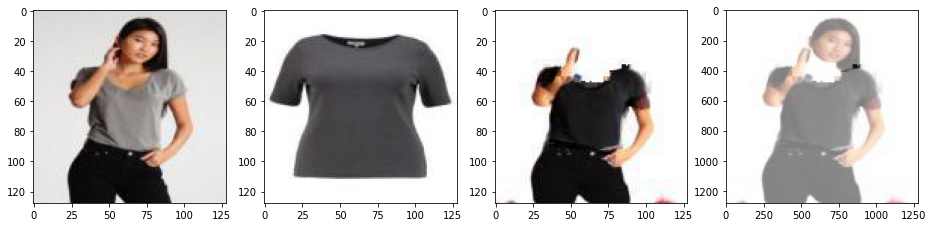

In [79]:
if __name__ == "__main__":
    main()